In-line Digital Holography Demonstration


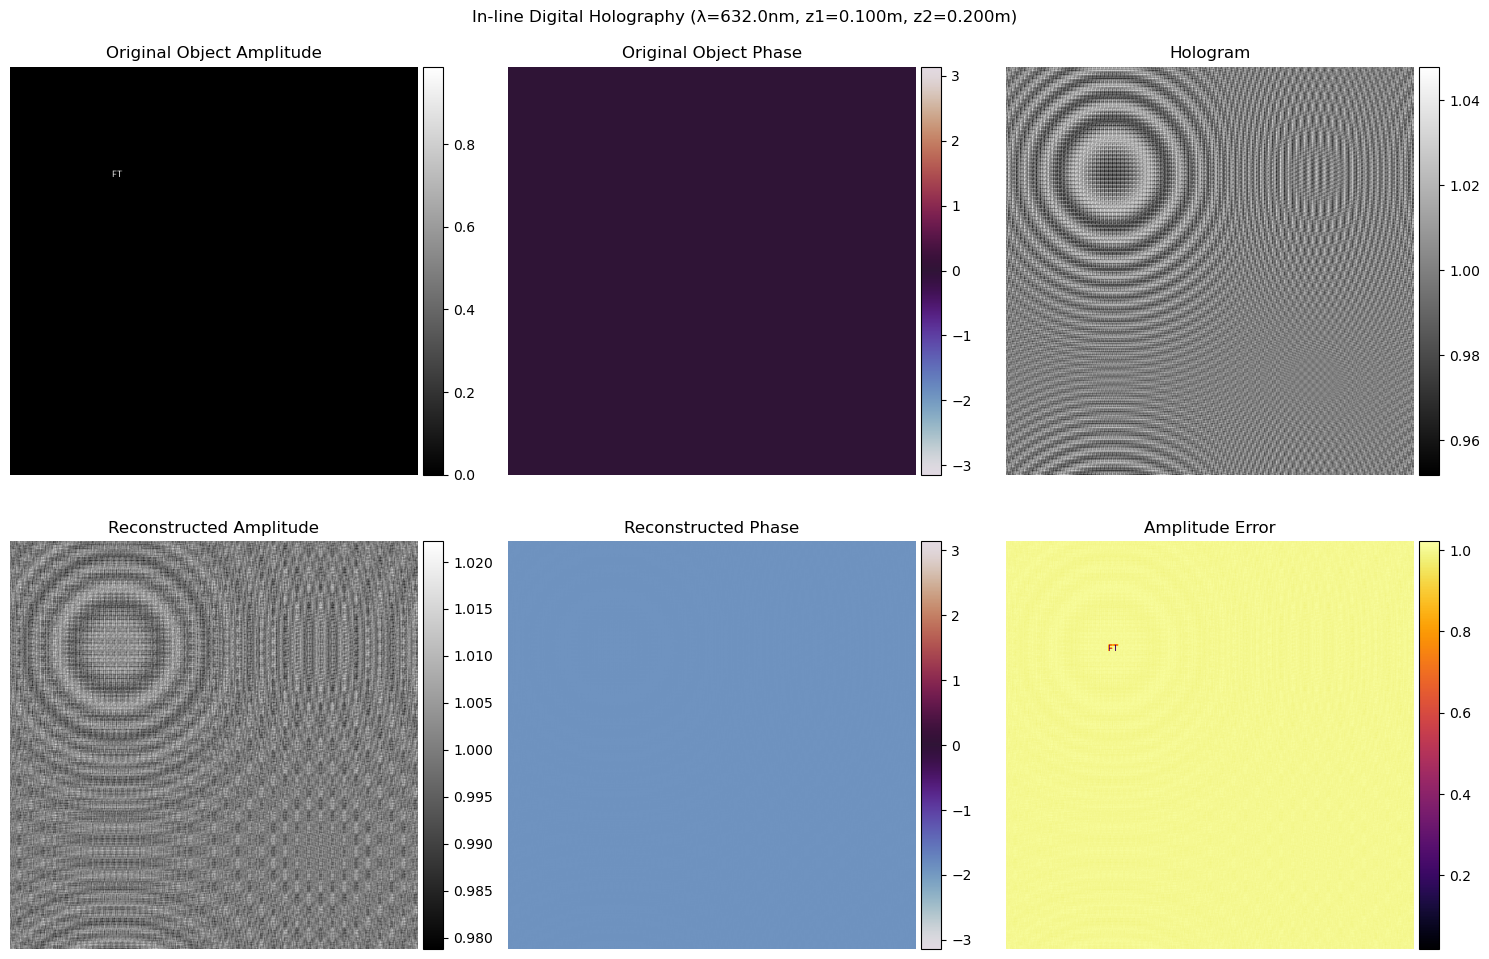

Mean absolute amplitude error: 0.999991
Max absolute amplitude error: 1.022224

Phase Retrieval Demonstration


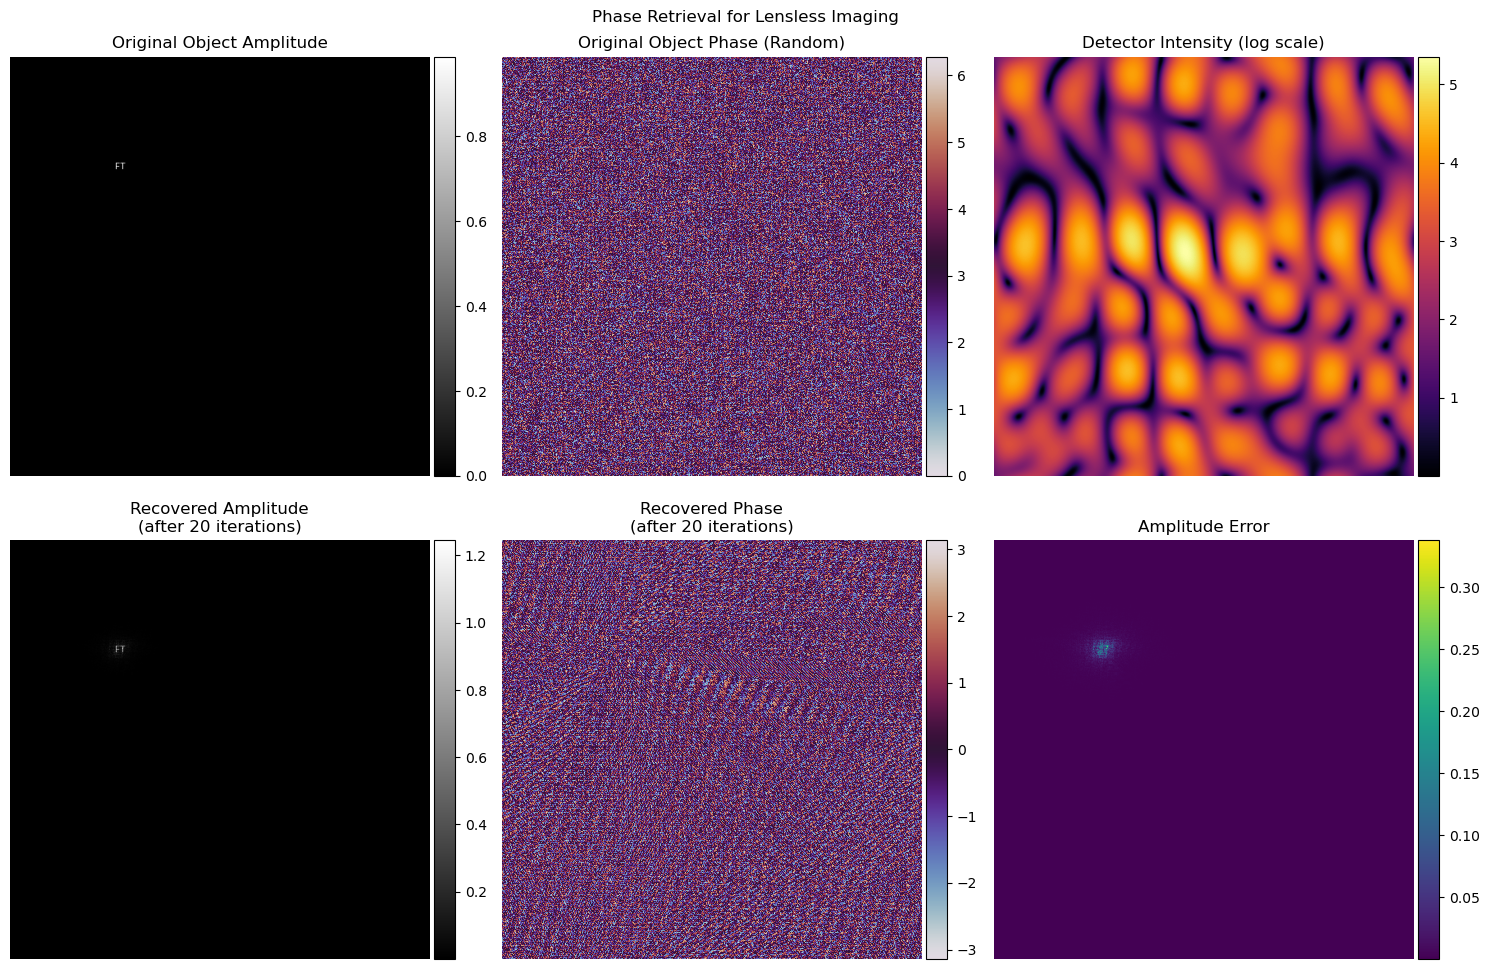

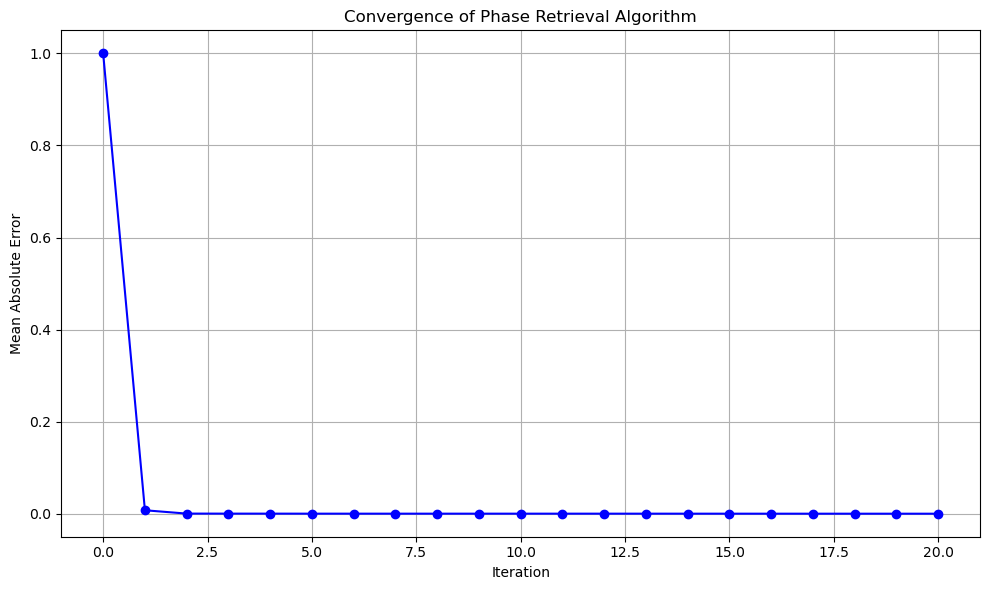


Coded Aperture Imaging Demonstration


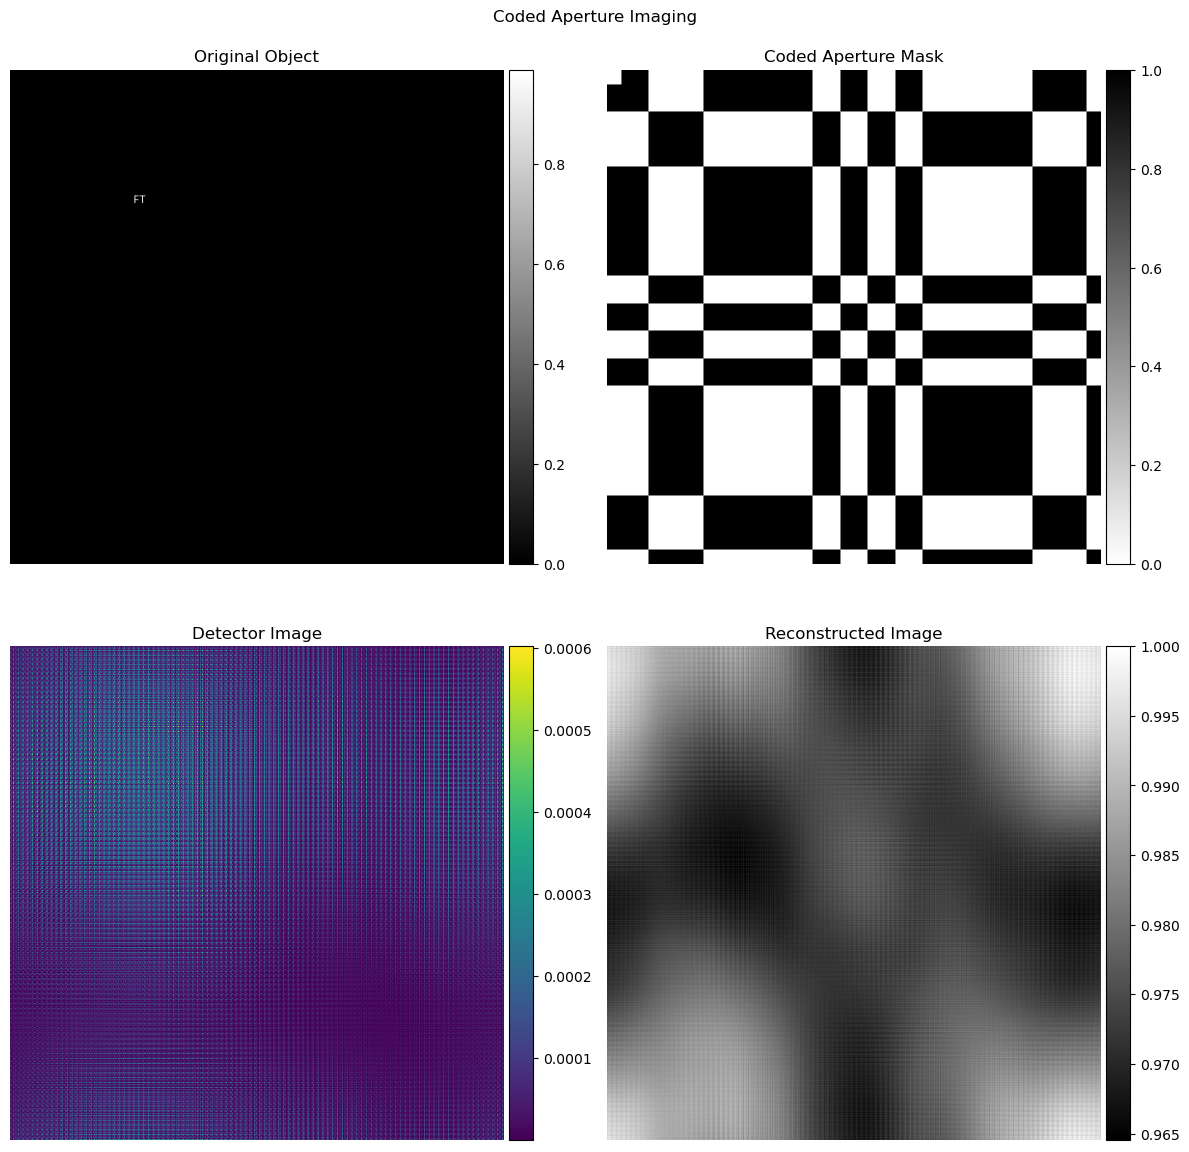

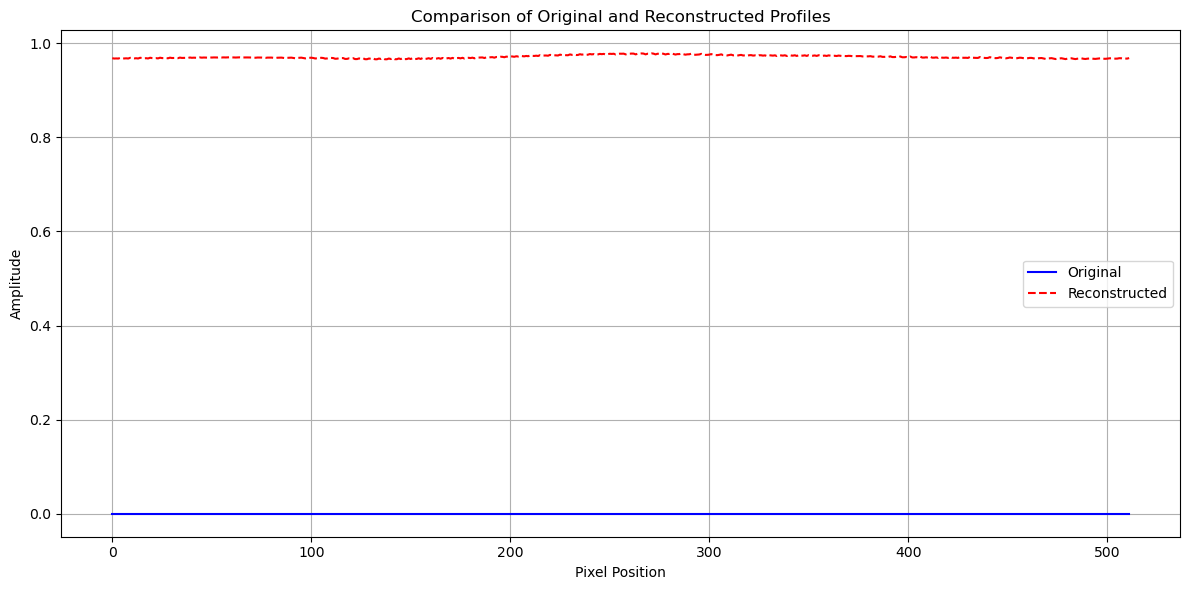

In [1]:
"""
lensless_imaging.py - Principles and techniques of lensless computational imaging

This module demonstrates lensless imaging techniques using Fourier optics concepts,
including in-line digital holography, phase retrieval, and coded aperture imaging.
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import scipy.fftpack as fft
from scipy import optimize
from mpl_toolkits.axes_grid1 import make_axes_locatable

def propagate_field(field, distance, wavelength, pixel_size):
    """
    Propagate a complex optical field using the angular spectrum method.
    
    Parameters:
    -----------
    field : 2D complex numpy array
        The complex field to propagate
    distance : float
        Propagation distance in meters
    wavelength : float
        Wavelength of light in meters
    pixel_size : float
        Size of each pixel in meters
    
    Returns:
    --------
    2D complex numpy array
        Propagated field
    """
    # Get dimensions of the field
    Ny, Nx = field.shape
    
    # Calculate spatial frequencies
    fx = fft.fftshift(fft.fftfreq(Nx, d=pixel_size))
    fy = fft.fftshift(fft.fftfreq(Ny, d=pixel_size))
    FX, FY = np.meshgrid(fx, fy)
    
    # Angular spectrum
    fft_field = fft.fftshift(fft.fft2(fft.ifftshift(field)))
    
    # Wave number
    k = 2 * np.pi / wavelength
    
    # Transfer function for propagation in free space
    # sqrt(1 - (lambda*fx)^2 - (lambda*fy)^2) is the z-component of the wave vector
    # H(fx,fy) = exp(i*k*z*sqrt(1 - (lambda*fx)^2 - (lambda*fy)^2))
    
    # Calculate z-component of wave vector
    tmp = 1 - (wavelength * FX)**2 - (wavelength * FY)**2
    
    # Evanescent waves (where tmp < 0) do not propagate
    prop_mask = tmp > 0
    transfer_function = np.zeros(field.shape, dtype=complex)
    transfer_function[prop_mask] = np.exp(1j * k * distance * np.sqrt(tmp[prop_mask]))
    
    # Apply transfer function
    fft_propagated = fft_field * transfer_function
    
    # Inverse Fourier transform to get propagated field
    propagated_field = fft.fftshift(fft.ifft2(fft.ifftshift(fft_propagated)))
    
    return propagated_field

def demonstrate_in_line_holography(object_amplitude, object_phase=None, z1=0.1, z2=0.2, wavelength=632e-9, pixel_size=5e-6):
    """
    Demonstrate in-line digital holography.
    
    Parameters:
    -----------
    object_amplitude : 2D numpy array
        Amplitude transmittance of the object
    object_phase : 2D numpy array, optional
        Phase shift introduced by the object (default: zero phase)
    z1 : float
        Distance from object to hologram plane in meters
    z2 : float
        Reconstruction distance in meters
    wavelength : float
        Wavelength of light in meters
    pixel_size : float
        Size of each pixel in meters
        
    Returns:
    --------
    tuple
        (hologram, reconstructed_amplitude, reconstructed_phase)
    """
    # Create complex object field
    if object_phase is None:
        object_phase = np.zeros_like(object_amplitude)
    
    object_field = object_amplitude * np.exp(1j * object_phase)
    
    # Propagate to hologram plane
    hologram_field = propagate_field(object_field, z1, wavelength, pixel_size)
    
    # Calculate hologram intensity (interference with reference wave)
    reference_wave = np.ones_like(hologram_field)  # Plane wave reference
    hologram = np.abs(hologram_field + reference_wave)**2
    
    # Reconstruct the object by propagating back
    reconstructed_field = propagate_field(np.sqrt(hologram), z2, wavelength, pixel_size)
    
    # Extract amplitude and phase
    reconstructed_amplitude = np.abs(reconstructed_field)
    reconstructed_phase = np.angle(reconstructed_field)
    
    # Plot the results
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f"In-line Digital Holography (λ={wavelength*1e9:.1f}nm, z1={z1:.3f}m, z2={z2:.3f}m)")
    
    # Plot original object
    im1 = axs[0, 0].imshow(object_amplitude, cmap='gray')
    axs[0, 0].set_title('Original Object Amplitude')
    axs[0, 0].set_axis_off()
    
    divider = make_axes_locatable(axs[0, 0])
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax1)
    
    im2 = axs[0, 1].imshow(object_phase, cmap='twilight', vmin=-np.pi, vmax=np.pi)
    axs[0, 1].set_title('Original Object Phase')
    axs[0, 1].set_axis_off()
    
    divider = make_axes_locatable(axs[0, 1])
    cax2 = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax2)
    
    # Plot hologram
    im3 = axs[0, 2].imshow(hologram, cmap='gray')
    axs[0, 2].set_title('Hologram')
    axs[0, 2].set_axis_off()
    
    divider = make_axes_locatable(axs[0, 2])
    cax3 = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im3, cax=cax3)
    
    # Plot reconstructed field
    im4 = axs[1, 0].imshow(reconstructed_amplitude, cmap='gray')
    axs[1, 0].set_title('Reconstructed Amplitude')
    axs[1, 0].set_axis_off()
    
    divider = make_axes_locatable(axs[1, 0])
    cax4 = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im4, cax=cax4)
    
    im5 = axs[1, 1].imshow(reconstructed_phase, cmap='twilight', vmin=-np.pi, vmax=np.pi)
    axs[1, 1].set_title('Reconstructed Phase')
    axs[1, 1].set_axis_off()
    
    divider = make_axes_locatable(axs[1, 1])
    cax5 = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im5, cax=cax5)
    
    # Plot error in reconstruction
    amplitude_error = np.abs(reconstructed_amplitude - object_amplitude)
    im6 = axs[1, 2].imshow(amplitude_error, cmap='inferno')
    axs[1, 2].set_title('Amplitude Error')
    axs[1, 2].set_axis_off()
    
    divider = make_axes_locatable(axs[1, 2])
    cax6 = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im6, cax=cax6)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics about reconstruction quality
    print(f"Mean absolute amplitude error: {np.mean(amplitude_error):.6f}")
    print(f"Max absolute amplitude error: {np.max(amplitude_error):.6f}")
    
    return hologram, reconstructed_amplitude, reconstructed_phase

def phase_retrieval_error(guess_phase, intensity, target_intensity):
    """
    Error function for phase retrieval optimization.
    
    Parameters:
    -----------
    guess_phase : 1D numpy array
        Flattened phase guess
    intensity : 2D numpy array
        Measured intensity at the detector
    target_intensity : 2D numpy array
        Target intensity (object amplitude squared)
        
    Returns:
    --------
    float
        Error metric (sum of squared differences)
    """
    # Reshape phase guess
    phase = guess_phase.reshape(intensity.shape)
    
    # Create complex field using measured amplitude and guessed phase
    field = np.sqrt(intensity) * np.exp(1j * phase)
    
    # Propagate to object plane (using inverse Fourier transform in this simple case)
    object_field = fft.ifft2(field)
    object_intensity = np.abs(object_field)**2
    
    # Calculate error
    error = np.sum((object_intensity - target_intensity)**2)
    
    return error

def demonstrate_phase_retrieval(object_amplitude, iterations=10, wavelength=632e-9, pixel_size=5e-6):
    """
    Demonstrate phase retrieval for lensless imaging.
    
    Parameters:
    -----------
    object_amplitude : 2D numpy array
        Amplitude of the object
    iterations : int
        Number of Gerchberg-Saxton algorithm iterations
    wavelength : float
        Wavelength of light in meters
    pixel_size : float
        Size of each pixel in meters
        
    Returns:
    --------
    tuple
        (recovered_amplitude, recovered_phase)
    """
    # Create object with random phase
    np.random.seed(42)  # For reproducibility
    object_phase = np.random.uniform(0, 2*np.pi, object_amplitude.shape)
    object_field = object_amplitude * np.exp(1j * object_phase)
    
    # Propagate to detector (using Fourier transform in this simple case)
    detector_field = fft.fft2(object_field)
    detector_intensity = np.abs(detector_field)**2
    
    # Initialize with random phase for recovery
    current_phase = np.random.uniform(0, 2*np.pi, detector_intensity.shape)
    
    # Storage for results
    phase_history = [current_phase.copy()]
    amplitude_history = [np.ones_like(object_amplitude)]
    
    # Gerchberg-Saxton algorithm
    for i in range(iterations):
        # Forward direction: detector plane
        detector_field = np.sqrt(detector_intensity) * np.exp(1j * current_phase)
        
        # Backward direction: object plane
        object_field = fft.ifft2(detector_field)
        recovered_amplitude = np.abs(object_field)
        recovered_phase = np.angle(object_field)
        
        # Replace amplitude with known object amplitude
        object_field = object_amplitude * np.exp(1j * recovered_phase)
        
        # Forward direction again
        detector_field = fft.fft2(object_field)
        current_phase = np.angle(detector_field)
        
        # Store results
        phase_history.append(current_phase.copy())
        amplitude_history.append(recovered_amplitude.copy())
    
    # Final reconstruction
    detector_field = np.sqrt(detector_intensity) * np.exp(1j * current_phase)
    object_field = fft.ifft2(detector_field)
    final_amplitude = np.abs(object_field)
    final_phase = np.angle(object_field)
    
    # Plot the results
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle("Phase Retrieval for Lensless Imaging")
    
    # Plot original object
    im1 = axs[0, 0].imshow(object_amplitude, cmap='gray')
    axs[0, 0].set_title('Original Object Amplitude')
    axs[0, 0].set_axis_off()
    
    divider = make_axes_locatable(axs[0, 0])
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax1)
    
    im2 = axs[0, 1].imshow(object_phase, cmap='twilight', vmin=0, vmax=2*np.pi)
    axs[0, 1].set_title('Original Object Phase (Random)')
    axs[0, 1].set_axis_off()
    
    divider = make_axes_locatable(axs[0, 1])
    cax2 = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax2)
    
    # Plot detector intensity
    im3 = axs[0, 2].imshow(np.log1p(detector_intensity), cmap='inferno')
    axs[0, 2].set_title('Detector Intensity (log scale)')
    axs[0, 2].set_axis_off()
    
    divider = make_axes_locatable(axs[0, 2])
    cax3 = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im3, cax=cax3)
    
    # Plot final reconstruction
    im4 = axs[1, 0].imshow(final_amplitude, cmap='gray')
    axs[1, 0].set_title(f'Recovered Amplitude\n(after {iterations} iterations)')
    axs[1, 0].set_axis_off()
    
    divider = make_axes_locatable(axs[1, 0])
    cax4 = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im4, cax=cax4)
    
    im5 = axs[1, 1].imshow(final_phase, cmap='twilight', vmin=-np.pi, vmax=np.pi)
    axs[1, 1].set_title(f'Recovered Phase\n(after {iterations} iterations)')
    axs[1, 1].set_axis_off()
    
    divider = make_axes_locatable(axs[1, 1])
    cax5 = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im5, cax=cax5)
    
    # Plot error in reconstruction
    amplitude_error = np.abs(final_amplitude - object_amplitude)
    im6 = axs[1, 2].imshow(amplitude_error, cmap='viridis')
    axs[1, 2].set_title('Amplitude Error')
    axs[1, 2].set_axis_off()
    
    divider = make_axes_locatable(axs[1, 2])
    cax6 = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im6, cax=cax6)
    
    plt.tight_layout()
    plt.show()
    
    # Plot convergence of the algorithm
    error_progression = []
    for i in range(len(amplitude_history)):
        error = np.mean(np.abs(amplitude_history[i] - object_amplitude))
        error_progression.append(error)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(error_progression)), error_progression, 'b-o')
    plt.xlabel('Iteration')
    plt.ylabel('Mean Absolute Error')
    plt.title('Convergence of Phase Retrieval Algorithm')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return final_amplitude, final_phase

def demonstrate_coded_aperture_imaging(object_amplitude, mask_pattern=None, wavelength=632e-9, pixel_size=5e-6, z=0.1):
    """
    Demonstrate coded aperture imaging.
    
    Parameters:
    -----------
    object_amplitude : 2D numpy array
        Amplitude of the object
    mask_pattern : 2D numpy array, optional
        Custom mask pattern (default: random binary mask)
    wavelength : float
        Wavelength of light in meters
    pixel_size : float
        Size of each pixel in meters
    z : float
        Distance from object to detector in meters
        
    Returns:
    --------
    tuple
        (detector_image, reconstructed_image)
    """
    # Create random binary mask if not provided
    if mask_pattern is None:
        np.random.seed(42)  # For reproducibility
        mask_pattern = np.random.randint(0, 2, object_amplitude.shape).astype(float)
    
    # Create object field
    object_field = object_amplitude.copy()
    
    # Apply coded aperture mask
    masked_field = object_field * mask_pattern
    
    # Propagate to detector
    detector_field = propagate_field(masked_field, z, wavelength, pixel_size)
    detector_image = np.abs(detector_field)**2
    
    # Reconstruct image using the correlation method
    # In the simplest form, we correlate the detector image with the mask pattern
    padded_mask = np.zeros_like(mask_pattern)
    center = np.array(padded_mask.shape) // 2
    pad_width = np.array(mask_pattern.shape) // 2
    
    # Pad mask to full size
    padded_mask[center[0]-pad_width[0]:center[0]+pad_width[0], 
               center[1]-pad_width[1]:center[1]+pad_width[1]] = mask_pattern
    
    # Compute correlation (using FFTs for efficiency)
    fft_detector = fft.fft2(detector_image)
    fft_mask = np.conj(fft.fft2(padded_mask))
    
    # Multiply in frequency domain (correlation in spatial domain)
    fft_reconstructed = fft_detector * fft_mask
    reconstructed_image = np.abs(fft.ifft2(fft_reconstructed))
    
    # Normalize for display
    reconstructed_image = reconstructed_image / np.max(reconstructed_image)
    
    # Plot the results
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    fig.suptitle("Coded Aperture Imaging")
    
    # Plot original object
    im1 = axs[0, 0].imshow(object_amplitude, cmap='gray')
    axs[0, 0].set_title('Original Object')
    axs[0, 0].set_axis_off()
    
    divider = make_axes_locatable(axs[0, 0])
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax1)
    
    # Plot mask pattern
    im2 = axs[0, 1].imshow(mask_pattern, cmap='binary')
    axs[0, 1].set_title('Coded Aperture Mask')
    axs[0, 1].set_axis_off()
    
    divider = make_axes_locatable(axs[0, 1])
    cax2 = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax2)
    
    # Plot detector image
    im3 = axs[1, 0].imshow(detector_image, cmap='viridis')
    axs[1, 0].set_title('Detector Image')
    axs[1, 0].set_axis_off()
    
    divider = make_axes_locatable(axs[1, 0])
    cax3 = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im3, cax=cax3)
    
    # Plot reconstructed image
    im4 = axs[1, 1].imshow(reconstructed_image, cmap='gray')
    axs[1, 1].set_title('Reconstructed Image')
    axs[1, 1].set_axis_off()
    
    divider = make_axes_locatable(axs[1, 1])
    cax4 = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im4, cax=cax4)
    
    plt.tight_layout()
    plt.show()
    
    # Compare original and reconstructed images
    plt.figure(figsize=(12, 6))
    
    # Get central profile
    center_y = object_amplitude.shape[0] // 2
    original_profile = object_amplitude[center_y, :]
    reconstructed_profile = reconstructed_image[center_y, :]
    
    plt.plot(original_profile, 'b-', label='Original')
    plt.plot(reconstructed_profile, 'r--', label='Reconstructed')
    plt.xlabel('Pixel Position')
    plt.ylabel('Amplitude')
    plt.title('Comparison of Original and Reconstructed Profiles')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return detector_image, reconstructed_image

def create_sample_object(shape, pattern_type='letters'):
    """
    Create a sample object for lensless imaging simulations.
    
    Parameters:
    -----------
    shape : tuple
        Shape of the object (height, width)
    pattern_type : str
        Type of pattern to create ('letters', 'shapes', or 'resolution')
        
    Returns:
    --------
    2D numpy array
        Object amplitude
    """
    h, w = shape
    
    if pattern_type == 'letters':
        # Create a pattern with letters "FT" for "Fourier Transform"
        from PIL import Image, ImageDraw, ImageFont
        
        # Create a blank image with white background
        img = Image.new('L', (w, h), color=0)
        draw = ImageDraw.Draw(img)
        
        # Draw text
        try:
            font = ImageFont.truetype("arial.ttf", size=h//2)
        except:
            font = ImageFont.load_default()
            
        draw.text((w//4, h//4), "FT", fill=255, font=font)
        
        # Convert to numpy array and normalize
        object_amplitude = np.array(img) / 255.0
        
    elif pattern_type == 'shapes':
        # Create a pattern with basic shapes
        object_amplitude = np.zeros((h, w))
        
        # Add a circle
        center_y, center_x = h//3, w//3
        radius = min(h, w) // 8
        y, x = np.ogrid[:h, :w]
        dist_from_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)
        circle_mask = dist_from_center <= radius
        object_amplitude[circle_mask] = 1.0
        
        # Add a rectangle
        rect_x, rect_y = 2*w//3, 2*h//3
        rect_w, rect_h = w//6, h//6
        object_amplitude[rect_y-rect_h//2:rect_y+rect_h//2, 
                        rect_x-rect_w//2:rect_x+rect_w//2] = 1.0
        
        # Add a triangle
        from scipy.spatial import ConvexHull
        
        # Triangle vertices
        triangle_center = np.array([w//2, h//2])
        triangle_radius = min(h, w) // 6
        angle = np.linspace(0, 2*np.pi, 4)[:-1]  # 3 points
        vertices = triangle_center + triangle_radius * np.column_stack([np.cos(angle), np.sin(angle)])
        
        # Create a grid of points
        y, x = np.mgrid[:h, :w]
        points = np.c_[x.ravel(), y.ravel()]
        
        # Create a ConvexHull for the triangle
        hull = ConvexHull(vertices)
        
        # Function to check if a point is inside the hull
        def in_hull(point, hull, tolerance=1e-12):
            return all(
                (np.dot(eq[:-1], point) + eq[-1] <= tolerance)
                for eq in hull.equations
            )
        
        # Check each point
        mask = np.zeros((h, w), dtype=bool)
        for i, point in enumerate(points):
            if in_hull(point, hull):
                mask[i // w, i % w] = True
        
        object_amplitude[mask] = 1.0
        
    elif pattern_type == 'resolution':
        # Create a resolution test pattern
        object_amplitude = np.zeros((h, w))
        
        # Add line pairs with decreasing separation
        line_width = max(1, min(h, w) // 100)
        for i in range(5):
            spacing = max(line_width, min(h, w) // 20 // (i + 1))
            start_x = w // 6 + i * w // 5
            for j in range(5):
                start_y = h // 6 + j * spacing * 2
                if start_y + spacing < h - h // 6:
                    object_amplitude[start_y:start_y+spacing, start_x:start_x+line_width*3] = 1.0
        
    else:
        raise ValueError("Unknown pattern type. Choose from 'letters', 'shapes', or 'resolution'.")
    
    return object_amplitude

def run_demonstrations():
    """Run all demonstrations in this module."""
    # Create a sample object
    size = 512
    object_amplitude = create_sample_object((size, size), 'letters')
    
    # Demonstrate in-line holography
    print("In-line Digital Holography Demonstration")
    hologram, reconstructed_amplitude, reconstructed_phase = demonstrate_in_line_holography(object_amplitude)
    
    # Demonstrate phase retrieval
    print("\nPhase Retrieval Demonstration")
    recovered_amplitude, recovered_phase = demonstrate_phase_retrieval(object_amplitude, iterations=20)
    
    # Demonstrate coded aperture imaging
    print("\nCoded Aperture Imaging Demonstration")
    # Create a specific coded aperture pattern (MURA - Modified Uniformly Redundant Array)
    # This is a simplified version for demonstration
    mura_size = 19  # Prime number
    mura_pattern = np.zeros((mura_size, mura_size))
    
    for i in range(mura_size):
        for j in range(mura_size):
            # MURA pattern generation rule
            if i == 0 and j == 0:
                mura_pattern[i, j] = 0
            elif i == 0:
                # Check if j is a quadratic residue modulo mura_size
                is_residue = False
                for k in range(1, mura_size):
                    if (k*k) % mura_size == j:
                        is_residue = True
                        break
                mura_pattern[i, j] = 1 if is_residue else 0
            elif j == 0:
                # Check if i is a quadratic residue modulo mura_size
                is_residue = False
                for k in range(1, mura_size):
                    if (k*k) % mura_size == i:
                        is_residue = True
                        break
                mura_pattern[i, j] = 1 if is_residue else 0
            else:
                # Check if i*j is a quadratic residue modulo mura_size
                is_residue = False
                for k in range(1, mura_size):
                    if (k*k) % mura_size == (i*j) % mura_size:
                        is_residue = True
                        break
                mura_pattern[i, j] = 1 if is_residue else 0
    
    # Resize and tile the pattern to match the object size
    from scipy.ndimage import zoom
    scaling_factor = size / mura_size
    large_mura = zoom(mura_pattern, scaling_factor, order=0)
    
    # Demonstrate with the MURA pattern
    detector_image, reconstructed_image = demonstrate_coded_aperture_imaging(object_amplitude, large_mura)

if __name__ == "__main__":
    run_demonstrations()
    
